In [13]:
from dotenv import load_dotenv
load_dotenv(override=True)

True

In [14]:
from app import langsmith_rag

question = "Why is transparency important in AI systems?"
langsmith_rag(question)


"Transparency is important in AI systems because it allows stakeholders to understand how decisions are made and ensures accountability. It helps build trust between users and the technology by enabling oversight and evaluation of the algorithms' processes. Additionally, transparency can facilitate compliance with regulations and ethical standards."

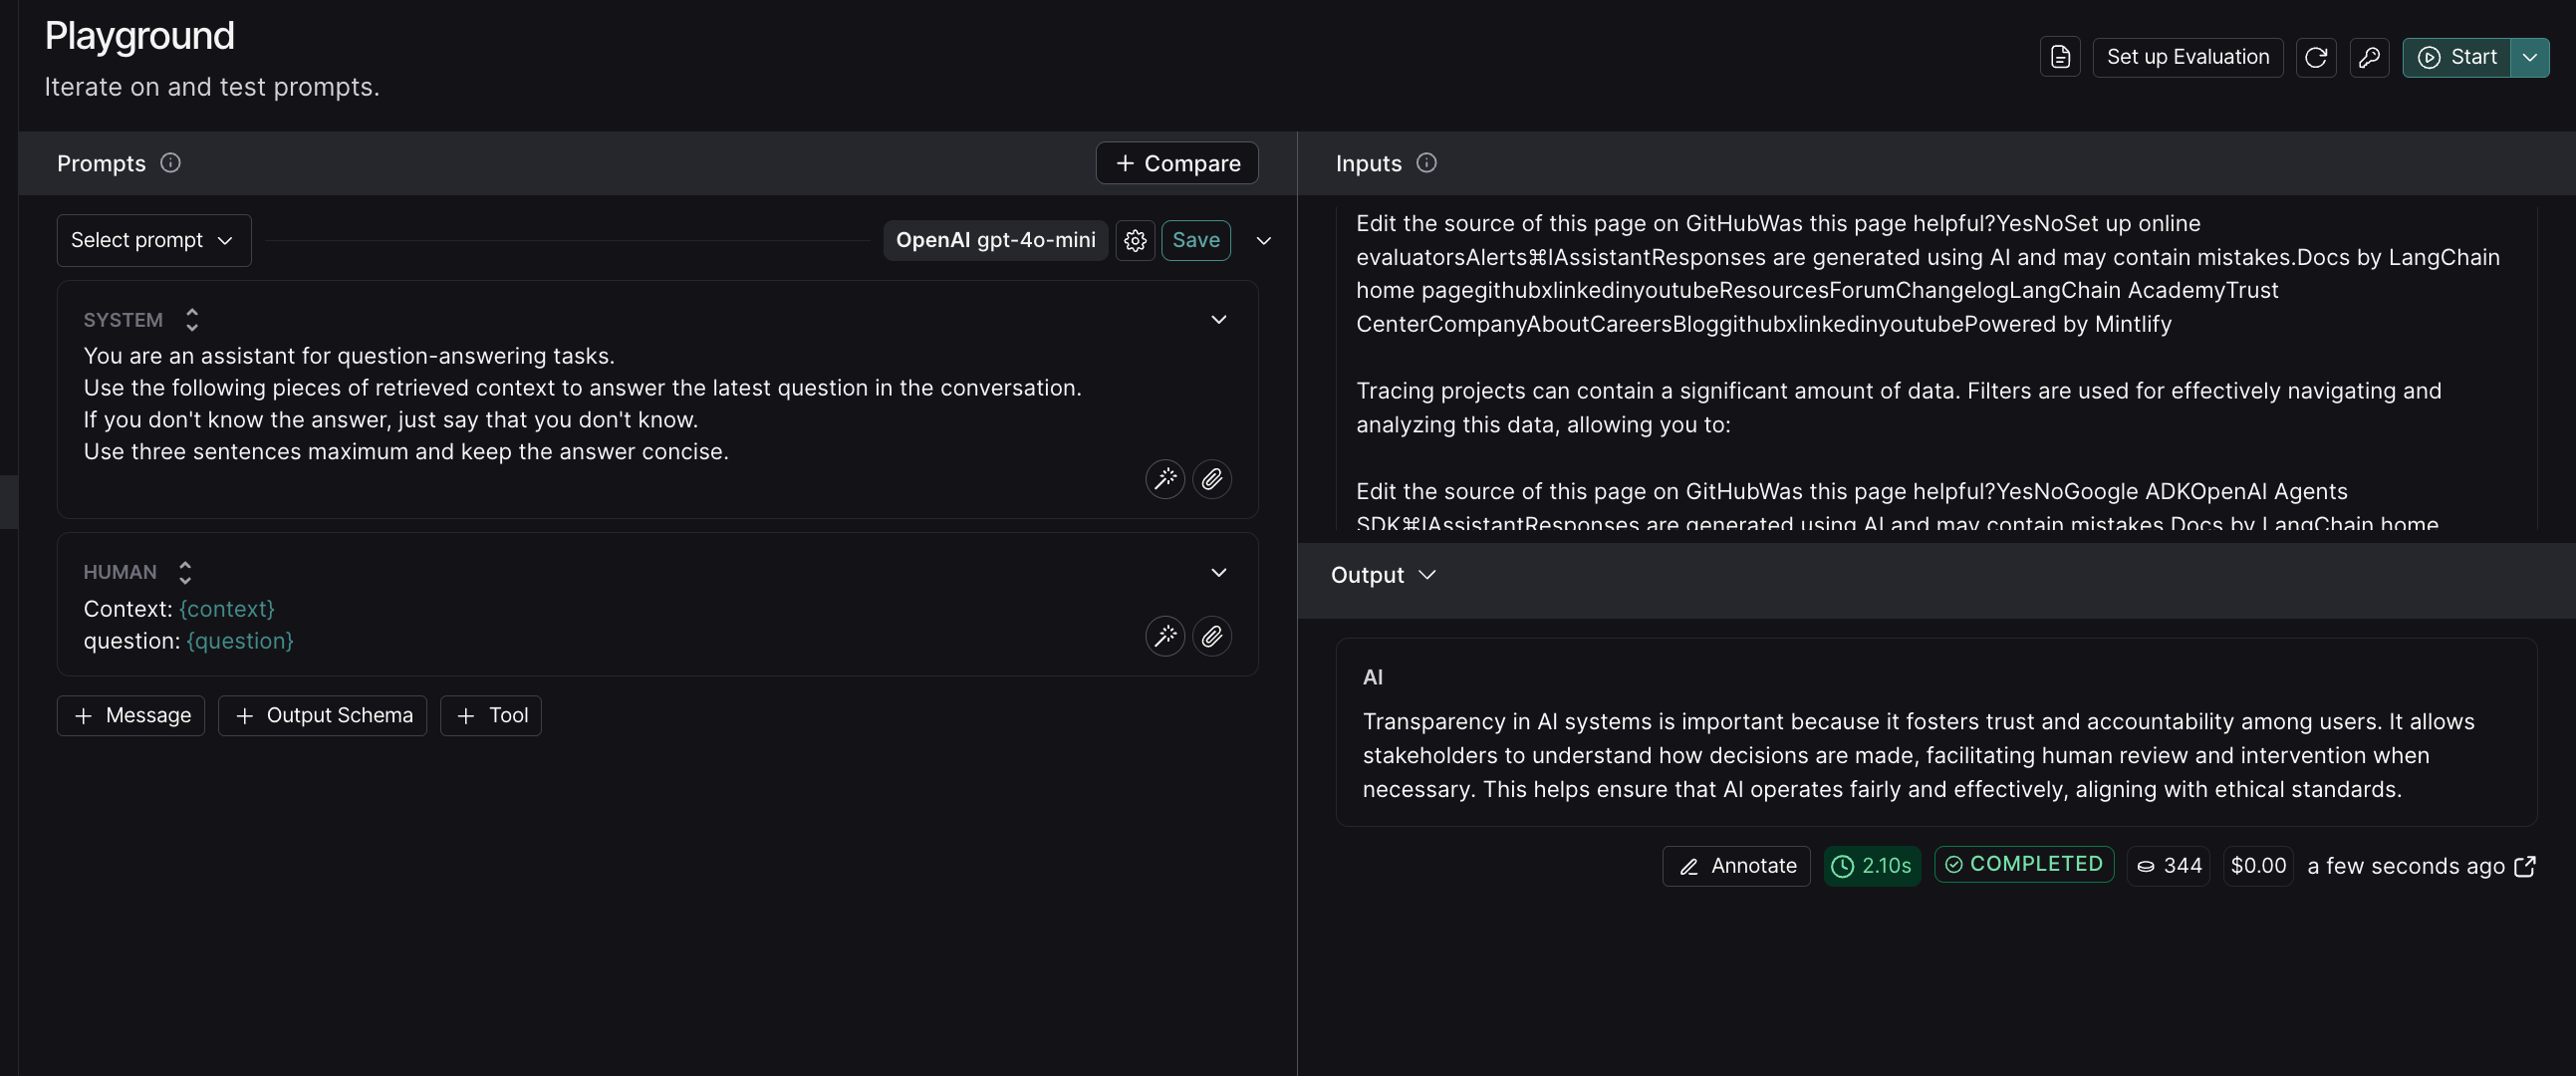

### Creating a dataset

In [20]:
from langsmith import Client

# Example data for a totally different topic
ai_ethics_dataset = [
    (
        "What is AI ethics?",
        """AI ethics is a field that studies how to design, deploy, and use artificial intelligence responsibly,
        ensuring fairness, transparency, and accountability.""",
        "AI ethics is about ensuring that artificial intelligence systems are developed and used responsibly. It focuses on issues like fairness, transparency, privacy, and bias. The goal is to make sure AI benefits society without causing harm or discrimination."
    ),
    (
        "Why is bias a problem in AI?",
        """AI bias occurs when training data or algorithms reflect unfair assumptions or stereotypes, leading to discriminatory outcomes.""",
        "Bias in AI can result in unfair treatment of individuals or groups. For example, if a facial recognition system is trained mostly on lighter skin tones, it might perform poorly on darker ones. Addressing bias means improving data diversity and monitoring model outcomes."
    ),
    (
        "How can we make AI more transparent?",
        """Transparency means making AI systems understandable to users and regulators. This includes explainable models and open documentation.""",
        "We can make AI more transparent by using explainable AI (XAI) methods, publishing model documentation, and clearly showing how decisions are made. This helps people trust AI and hold organizations accountable."
    ),
]

# Initialize LangSmith client (used only to structure and store data — not LangSmith-related content)
client = Client()

# Define a new dataset name
dataset_name = "ai_ethics_dataset"

# Create a new dataset
dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="A dataset containing questions and answers related to AI ethics, fairness, and social impact."
)

# Prepare structured data
inputs = [{"question": q, "context": c} for q, c, _ in ai_ethics_dataset]
outputs = [{"output": o} for _, _, o in ai_ethics_dataset]

# Create examples in the dataset
client.create_examples(
    inputs=inputs,
    outputs=outputs,
    dataset_id=dataset.id,
)


{'example_ids': ['2a675c8a-b700-4e21-8e42-aebcaeadcacc',
  '9da84e9b-8716-4605-835d-2dd12c265a4b',
  '0e95e52b-c6df-42b9-85fd-f9ccbfe9919e'],
 'count': 3}

In [25]:
# Create a LANGSMITH_API_KEY in Settings > API Keys
from langsmith import Client
client = Client()
prompt = client.pull_prompt("ai_ethics_prompt")

In [28]:
import os
import tempfile
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders.sitemap import SitemapLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_openai import OpenAIEmbeddings
from langsmith import traceable
from langsmith.client import convert_prompt_to_openai_format
from openai import OpenAI
from typing import List
import nest_asyncio

MODEL_NAME = "gpt-4o-mini"
MODEL_PROVIDER = "openai"
APP_VERSION = 1.0

openai_client = OpenAI()

def get_vector_db_retriever():
    persist_path = os.path.join(tempfile.gettempdir(), "union.parquet")
    embd = OpenAIEmbeddings()

    # If vector store exists, then load it
    if os.path.exists(persist_path):
        vectorstore = SKLearnVectorStore(
            embedding=embd,
            persist_path=persist_path,
            serializer="parquet"
        )
        return vectorstore.as_retriever(lambda_mult=0)

    # Otherwise, index LangSmith documents and create new vector store
    ls_docs_sitemap_loader = SitemapLoader(web_path="https://docs.smith.langchain.com/sitemap.xml", continue_on_failure=True)
    ls_docs = ls_docs_sitemap_loader.load()

    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=500, chunk_overlap=0
    )
    doc_splits = text_splitter.split_documents(ls_docs)

    vectorstore = SKLearnVectorStore.from_documents(
        documents=doc_splits,
        embedding=embd,
        persist_path=persist_path,
        serializer="parquet"
    )
    vectorstore.persist()
    return vectorstore.as_retriever(lambda_mult=0)

nest_asyncio.apply()
retriever = get_vector_db_retriever()

"""
retrieve_documents
- Returns documents fetched from a vectorstore based on the user's question
"""
@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

"""
generate_response
- Calls `call_openai` to generate a model response after formatting inputs
"""
@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    formatted_prompt = prompt.invoke({"context": " " , "question": question})
    messages = convert_prompt_to_openai_format(formatted_prompt)["messages"]
    return call_openai(messages)

"""
call_openai
- Returns the chat completion output from OpenAI
"""
@traceable(
    run_type="llm",
    metadata={
        "ls_provider": MODEL_PROVIDER,
        "ls_model_name": MODEL_NAME
    }
)
def call_openai(messages: List[dict]) -> str:
    return openai_client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
    )

"""
langsmith_rag
- Calls `retrieve_documents` to fetch documents
- Calls `generate_response` to generate a response based on the fetched documents
- Returns the model response
"""
@traceable(run_type="chain")
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content


In [29]:
question = "Why is transparency important in AI systems?"
langsmith_rag(question)

'Transparency in AI systems is important because it fosters trust among users, enabling them to understand how decisions are made. It also helps identify and mitigate biases, ensuring fairness and ethical use of technology. Moreover, transparency allows for accountability in cases where AI systems may cause harm or make errors.'

### new prompt in the prompt hub

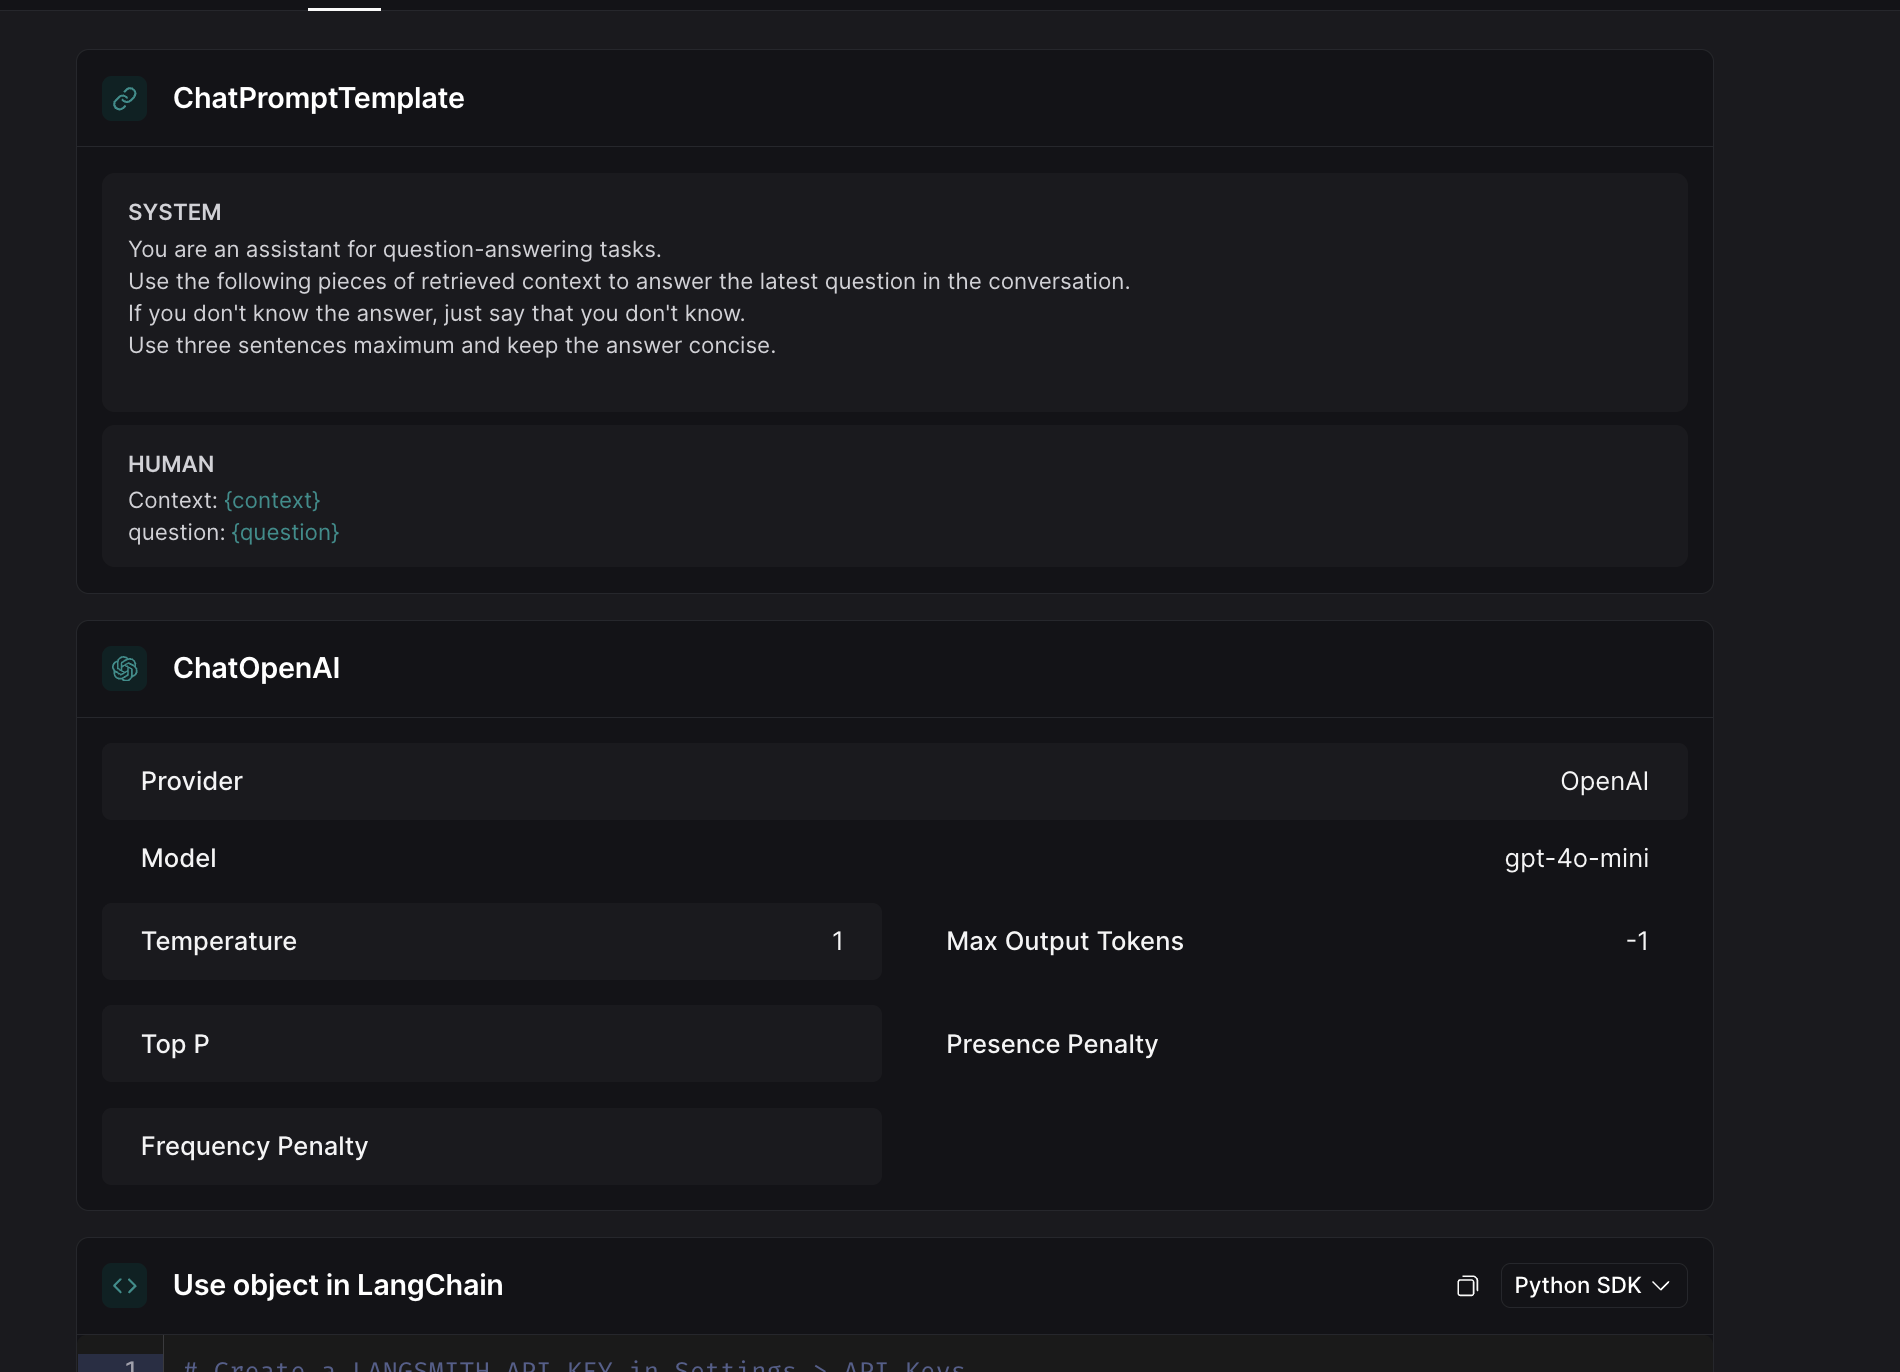

### Output of running an experiment on the given dataset

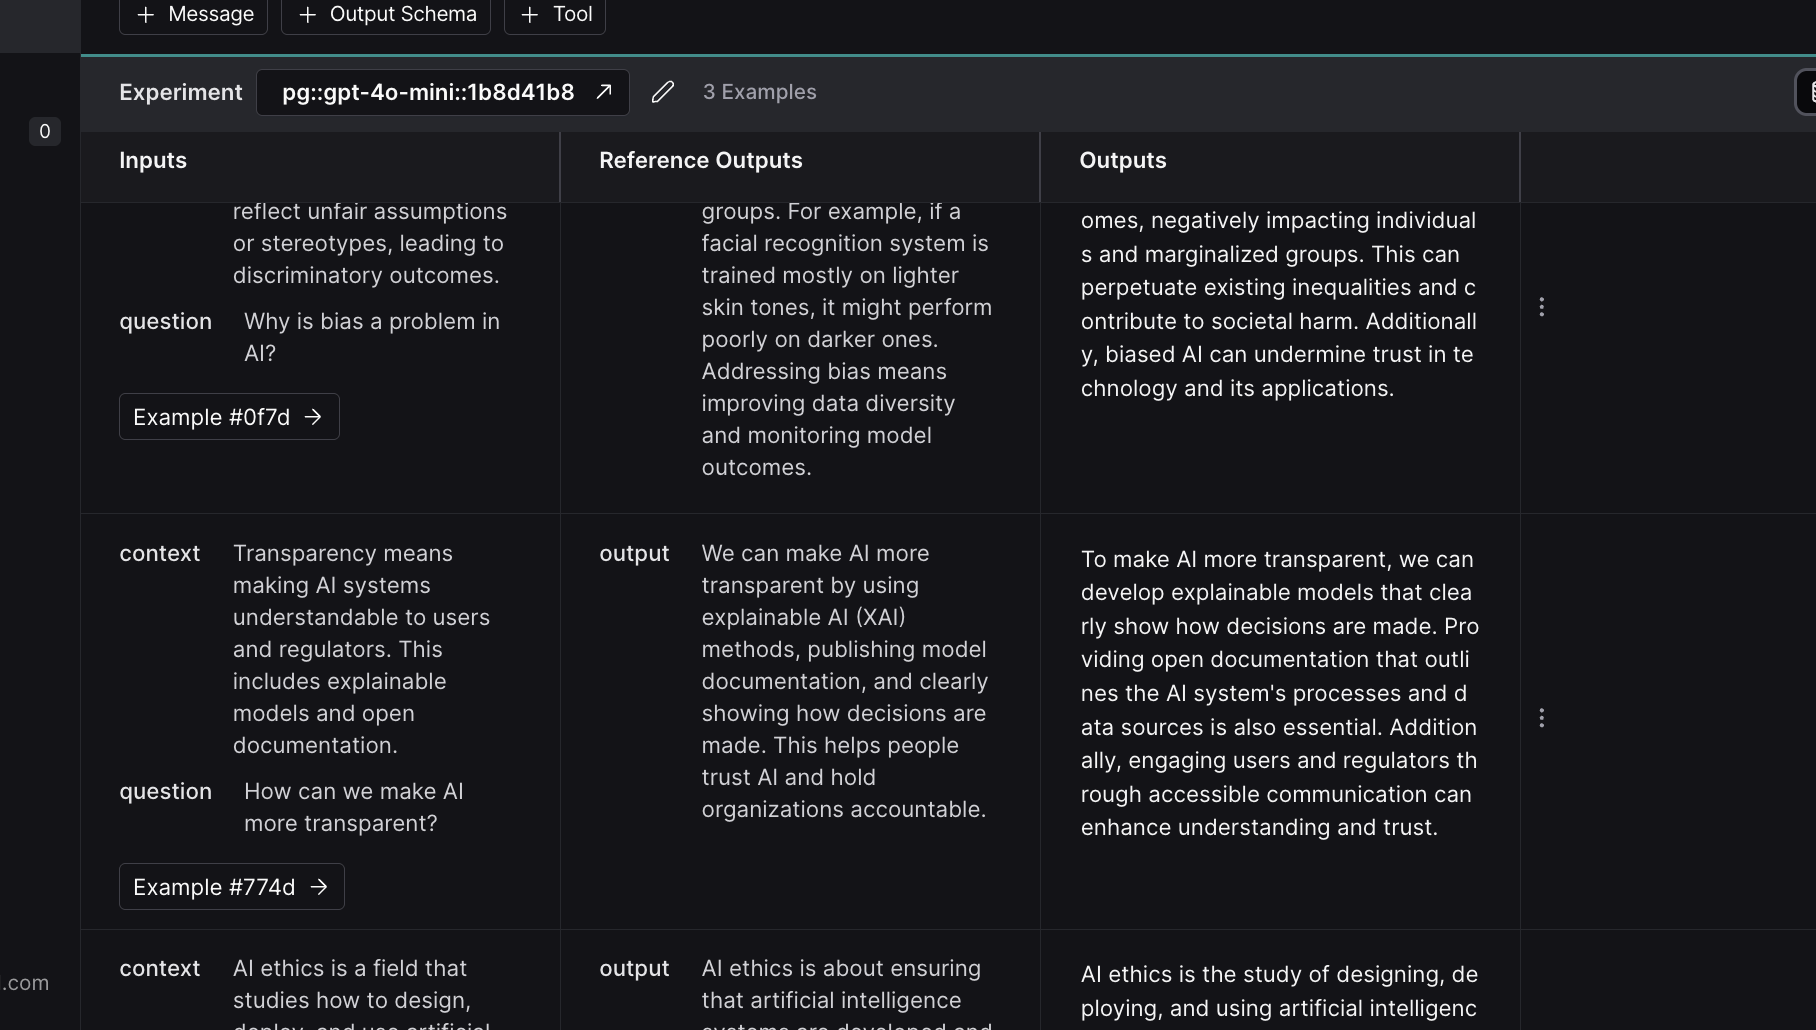